In [44]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from imblearn.over_sampling import SMOTE

from autograd import grad
import autograd.numpy as np

df = pd.read_csv("Non_Textual_and_Textual_Features.csv")

# Function to create labels based on the Boolean columns BUG and BIC of the dataset. Necessary for our dataset, might be optional for others.
def label_bool(is_bug,bic):
    if(is_bug==1 and bic==1):
        return 1 # Intrinsic
    elif(is_bug==1 and bic==0):
        return 0 # Extrinsic
    else:
        return -1 # Non-bug
    
df["Label"]=df.apply(lambda x: label_bool(x['BUG'],x['BIC']),axis=1)
df = df[df['Label']>-1]

df.head()

,Unnamed: 0.2,commit_id,author_date,bugcount,fixcount,la,ld,nf,nd,ns,...,BugId,Project,FixHashId,BUG,BIC,Comments,title,description,BFC_message,Label
0,0,0049967a874a3dca7c6ab8e8e84ca7dea21dc0b2,1395160653,0.0,1.0,29,12,2,2,1,...,1284162,neutron,0049967a874a3dca7c6ab8e8e84ca7dea21dc0b2,1,1,NaN,"Bug #1284162 in neutron: ""Cisco plugin fails t...",When the Cisco nexus plugin is configured on D...,Cisco plugin fails with ParseError no elem fou...,1
2,2,00ac56a100ac7329a01b5f1fa336b99e64778eaf,1401120475,NaN,1.0,16,4,4,3,1,...,1322180,nova,00ac56a100ac7329a01b5f1fa336b99e64778eaf,1,0,"""Legacy bdm in incoming parameters contains a ...","Bug #1322180 in OpenStack Compute (nova): ""Fai...",Launting an instance from bootable volume pass...,Run instance root device determination fix.\n\...,0
3,3,00f5125745dc72afbc9aeade8b780d7a3be49a30,1394439616,NaN,1.0,5,1,2,2,1,...,1288926,nova,00f5125745dc72afbc9aeade8b780d7a3be49a30,1,1,bug rebooting,"Bug #1288926 in OpenStack Compute (nova): ""inc...",This is using the latest nova from trunk. In o...,Don't allow reboot when instance in rebooting_...,1
4,4,011d99f300ea5d5f4ce48023bd04a795a4872287,1369792347,3.0,1.0,87,47,2,2,1,...,1175695,neutron,011d99f300ea5d5f4ce48023bd04a795a4872287,1,1,,"Bug #1175695 in neutron: ""L3 agent restart cau...","When L3 agent is restarted, it destroys all ex...",L3 Agent restart causes network outage\n\nWhen...,1
5,5,0125cf7815acb677b619905e2d9d258a9bae1c48,1407713999,NaN,1.0,3,2,2,2,1,...,1355759,neutron,0125cf7815acb677b619905e2d9d258a9bae1c48,1,1,NaN,"Bug #1355759 in neutron: ""L2populationRpcCallB...",L2populationRpcCallBackTunnelMixin get_agent_p...,"l2pop: get_agent_ports: Don't yield (None, {})...",1


# Data Clean up and processing

- Converting boolean columns values to either 1 (true) or 0 (false)
- Replacing NaN Values by zero (0)
- Normalizing the data (scaling it down twice)
- Defining the Independent and dependent variable

In [45]:
# Converting boolean columns to 1 and 0
df['revd'] = df['revd'].apply(lambda x: 1 if x==True else 0)
df['self'] = df['self'].apply(lambda x: 1 if x==True else 0)

#Feature selection 3:33 all featurs
print(df.columns[3:33])
columns=list(df.columns[3:33])

# Defining x and y
x = df[columns]
y = df['Label']

x = x.fillna(0)                                  # Replacing NaN values with the mean of that column
x_norm = (x-x.min())/(x.max()-x.min())        # Normalizing the data
x= x_norm

# Converting to numpy array
x = np.array(x)
y = np.array(y)

Index(['bugcount', 'fixcount', 'la', 'ld', 'nf', 'nd', 'ns', 'ent', 'revd',
       'nrev', 'rtime', 'tcmt', 'hcmt', 'self', 'ndev', 'age', 'nuc', 'app',
       'aexp', 'rexp', 'oexp', 'arexp', 'rrexp', 'orexp', 'asexp', 'rsexp',
       'osexp', 'asawr', 'rsawr', 'osawr'],
      dtype='object')


# Train Test Splitting the dataset

In [38]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)
# print(x_train.shape, y_train.shape)

(892, 30) (892,)


In [39]:
def class_balancing(X, y):
    # Perform class balancing using SMOTE
    smote = SMOTE()
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced

def model(x,w):
    # generate polynomial function of degree = d
    polynomial_features = PolynomialFeatures(d)
    x_poly = polynomial_features.fit_transform(x)
    return np.dot(x_poly,w)
    #return w[0]+np.dot(x_poly,w[1:])

def sigmoid(t):
    return 1/(1+np.exp(-t)) #tanhyperbolic

def cross_entropy(w,x,y):
    a = sigmoid(model(x,w))
    ind = np.argwhere(y==0)[:,0]
    cost = -5*np.sum(np.log(1-a[ind]))
    
    ind = np.argwhere(y==1)[:,0]
    cost -= np.sum(np.log(a[ind]))
    cost = cost/y.size
    cost += lambda_*norm(w[1:],1)
    return cost

def gradient_descent(g,step,max_iter,w):
    gradient = grad(g)
    weight_history = [w]
    cost_history = [g(w)]
    
    for k in range(max_iter):
        grad_eval = gradient(w) #get the gradient
        grad_eval_norm = grad_eval/np.linalg.norm(grad_eval)  #Normalized gradient descent
        w = w - step*grad_eval_norm
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history, cost_history

def c(w):
    c = cross_entropy(w,x_train,y_train)
    return c

(1332, 30)
['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12'
 'x13' 'x14' 'x15' 'x16' 'x17' 'x18' 'x19' 'x20' 'x21' 'x22' 'x23' 'x24'
 'x25' 'x26' 'x27' 'x28' 'x29']
31
[10.          8.88888889  7.77777778  6.66666667  5.55555556  4.44444444
  3.33333333  2.22222222  1.11111111  0.        ]


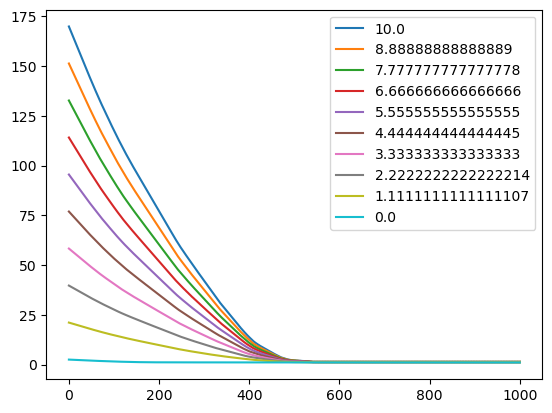

In [52]:
iter = 1000
print(x.shape)

global d, lambda_
d = 1
polynomial_features = PolynomialFeatures(d)
x_poly = polynomial_features.fit_transform(x)
print(polynomial_features.get_feature_names_out())
print(x_poly.shape[1])
w = np.array(np.random.rand(x_poly.shape[1],1))

lambda_array = np.linspace(10,0,10)
print(lambda_array)
b_array = []
a_array = []
for lambda_ in lambda_array:
    a, b = gradient_descent(c,0.01,iter,w)
    a_array.append(a)
    b_array.append(b)
    #plt.plot(b)
    #plt.show()
plt.figure(1)
for i in range(len(b_array)):
    plt.plot(b_array[i])
plt.legend(lambda_array)
# plt.show()

In [53]:
print(a_array[9][iter])
print(len(df.columns[3:33]))
tally = dict(zip(df.columns[3:33],a_array[9][iter][1:]))
print(tally)

[[-0.85158156]
 [ 1.87518029]
 [-0.36272974]
 [-0.78212304]
 [ 0.54254613]
 [-2.40601098]
 [-1.11300089]
 [-0.28848566]
 [ 0.09100658]
 [ 0.9335112 ]
 [-0.61106296]
 [-1.01313472]
 [ 0.44654377]
 [ 0.89155253]
 [ 1.43625554]
 [ 0.12890681]
 [-2.41146046]
 [ 0.87159623]
 [ 2.72531785]
 [ 0.09998042]
 [ 0.47751137]
 [ 0.28765633]
 [-1.23414796]
 [-0.90118351]
 [-0.21224632]
 [ 0.47040308]
 [ 0.07249299]
 [ 0.49398672]
 [ 0.05812496]
 [-0.04951552]
 [ 0.08997951]]
30
{'bugcount': array([1.87518029]), 'fixcount': array([-0.36272974]), 'la': array([-0.78212304]), 'ld': array([0.54254613]), 'nf': array([-2.40601098]), 'nd': array([-1.11300089]), 'ns': array([-0.28848566]), 'ent': array([0.09100658]), 'revd': array([0.9335112]), 'nrev': array([-0.61106296]), 'rtime': array([-1.01313472]), 'tcmt': array([0.44654377]), 'hcmt': array([0.89155253]), 'self': array([1.43625554]), 'ndev': array([0.12890681]), 'age': array([-2.41146046]), 'nuc': array([0.87159623]), 'app': array([2.72531785]), 'aexp'

In [11]:
y_pred = np.sign(sigmoid(model(x_test, a[iter]))- 0.5)/2 +0.5

# print(confusion_matrix(y_test,y_pred))
# print(accuracy_score(y_test,y_pred))

# print(classification_report(y_test, y_pred))

[[ 17  53]
 [119 251]]
0.6090909090909091
              precision    recall  f1-score   support

           0       0.12      0.24      0.17        70
           1       0.83      0.68      0.74       370

    accuracy                           0.61       440
   macro avg       0.48      0.46      0.45       440
weighted avg       0.71      0.61      0.65       440



In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(x_train, y_train)

y_pred2 = classifier.predict(x_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))

In [46]:
print(x.shape, y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42, stratify=y)
print(x_test.shape, y_test.shape)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=42, stratify=y_test)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1332, 30) (1332,)
(400, 30) (400,)
(932, 30) (932,)
(200, 30) (200,)
(200, 30) (200,)


[20.         18.95263158 17.90526316 16.85789474 15.81052632 14.76315789
 13.71578947 12.66842105 11.62105263 10.57368421  9.52631579  8.47894737
  7.43157895  6.38421053  5.33684211  4.28947368  3.24210526  2.19473684
  1.14736842  0.1       ]
[0.05, 0.05276312135517912, 0.05584950029394474, 0.05931938807368092, 0.06324900133155792, 0.0677361853832442, 0.07290867229470453, 0.07893643539675944, 0.08605072463768115, 0.09457441513190641, 0.10497237569060773, 0.11793916821849781, 0.13456090651558072, 0.156636438582028, 0.18737672583826426, 0.23312883435582815, 0.30844155844155835, 0.45563549160671435, 0.8715596330275219, 10.0]
246.98216457994687


ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

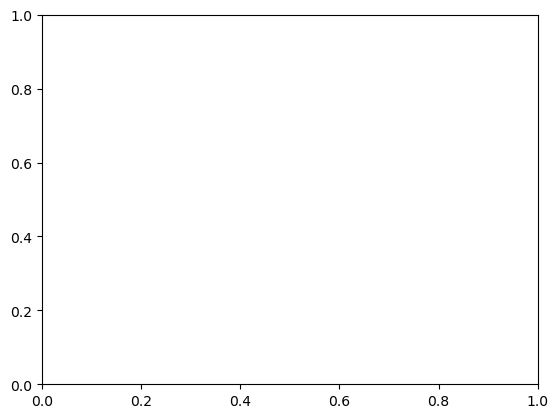

In [71]:
iter = 100

global d, lambda_
d = 1
polynomial_features = PolynomialFeatures(d)
x_poly = polynomial_features.fit_transform(x)
#print(x_poly.shape[1])
w = np.array(np.random.rand(x_poly.shape[1],1))

lambda_array = np.linspace(20,0.1,20)
print(lambda_array)
cost_train_array = []
a_array = []
cost_val_array = []
i=0
for lambda_ in lambda_array:
    a, b = gradient_descent(c,0.01,iter,w)
    cost_val = cross_entropy(a[iter],x_val,y_val)
    i+=1
    a_array.append(a)
    cost_train_array.append(b)
    cost_val_array.append(cost_val)
    
plt.figure(1)
lam = [1/x for x in lambda_array]
print(lam)
for i in range(len(cost_train_array)):
    print(cost_train_array[i][iter])
    plt.plot(lam, cost_train_array[i][iter], label="train")
    plt.plot(lam, cost_val_array[i], label="val")

#plt.legend(lambda_array)
plt.show()

/Users/pragya/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pragya/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pragya/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pragya/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Use

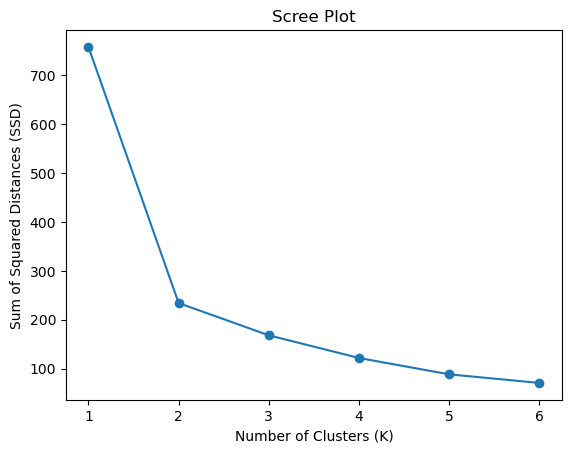

1
[[  5  65]
 [ 54 316]]
2
[[ 15  55]
 [107 263]]
3
[[  3  67]
 [ 26 344]]
4
[[  5  65]
 [ 40 330]]
5
[[  1  69]
 [ 10 360]]
6
[[  1  69]
 [ 19 351]]
7
[[  0  70]
 [  5 365]]
8
[[  1  69]
 [ 10 360]]
9
[[  0  70]
 [  5 365]]
10
[[  0  70]
 [  7 363]]
11
[[  0  70]
 [  3 367]]
12
[[  2  68]
 [  7 363]]
13
[[  1  69]
 [  1 369]]
14
[[  1  69]
 [  3 367]]
15
[[  0  70]
 [  0 370]]
16
[[  0  70]
 [  0 370]]
17
[[  0  70]
 [  0 370]]
18
[[  0  70]
 [  0 370]]
19
[[  0  70]
 [  0 370]]
[0.7295454545454545, 0.6318181818181818, 0.7886363636363637, 0.7613636363636364, 0.8204545454545454, 0.8, 0.8295454545454546, 0.8204545454545454, 0.8295454545454546, 0.825, 0.8340909090909091, 0.8295454545454546, 0.8409090909090909, 0.8363636363636363, 0.8409090909090909, 0.8409090909090909, 0.8409090909090909, 0.8409090909090909, 0.8409090909090909]


In [23]:
from sklearn.cluster import KMeans


# Sum of squared distances between clustered points
ssd = []

# Values of K to try
k_values = range(1, 7)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_train)
    ssd.append(kmeans.inertia_)

    
# Plot the scree plot
plt.plot(k_values, ssd, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.show()

from sklearn.neighbors import KNeighborsClassifier

k_range = range(1, 20)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    #print(confusion_matrix(y_test,y_pred))

#print(scores)
